# Welcome to the tutorial measuring intrinsic absorption parameter!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553

Hirose, T., Ueda, H., & Fujita, E. (2022). Scattering and intrinsic absorption parameters of Rayleigh waves at 18 active volcanoes in Japan inferred using seismic interferometry. Bulletin of Volcanology, 84(3), 34. https://doi.org/10.1007/s00445-022-01536-w

### This notebook demonstrates single-station measurements

Step: <br>
0) Data preparing and filtering <br> 1) Calculation of mean-squared (MS) envelopes --> observed energy densities (Eobs) <br> 
2) Calculation of synthesized energy densities (Esyn) via a grid search <br>
3) Determination of best-fit parameters: intrinsic absorption parameter *b* (for single station)<br>

In [1]:
import os
import sys
import glob
import obspy
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math

from obspy.signal.filter import bandpass
from scripts.Esyn_func import *

### Step 0 ---  Data preparing and filtering 

In [2]:
# detremine the h5 file for processing
path="/home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/"
sfiles = sorted(glob.glob(os.path.join(path, 'MPU*.h5')))
print("The h5 file: ",sfiles)
sta_pair=sfiles[0].split("H5/")[1].split(".h5")[0]
print("Processed station pair: ",sta_pair)

The h5 file:  ['/home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5']
Processed station pair:  MPU_MPU


In [3]:
# detremine the h5 file for processing
comp_arr = ["ZN", "ZE","NE", "EN","EZ","NZ"]               # component 
num_cmp=len(comp_arr)
fnum=len(sfiles)
print(fnum, num_cmp )

1 6


In [4]:
# information of the input data:  lagtime (lag), sampling rate (samp)
lag=100 #60
samp=20
leng=int(lag*samp*2+1)
npts=leng
print("Lag-time: ",lag,", sampling rate: ",samp,", total data length in points: ",leng)

Lag-time:  100 , sampling rate:  20 , total data length in points:  4001


In [5]:
def plot_waveforms(ncmp,wav,fname,comp_arr):
    fig, ax = plt.subplots(1,ncmp, figsize=(16,3), sharex=False)
    
    for n in range(ncmp):
        absy=max(wav[n][1], key=abs)
        ax[n].set_ylim(absy*-1,absy)
        ax[n].plot(wav[n][0],wav[n][1])
        ax[n].set_xlabel("time [s]")
        ax[n].set_title(fname+" "+comp_arr[n])
    fig.tight_layout()
    plt.show()

(1, 6, 2, 4001)
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 ZN
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 ZE
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 NE
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 EN
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 EZ
0 /home/kffeng/DVV_kura/COR/UU06-22/RCF_H5/MPU_MPU.h5 NZ


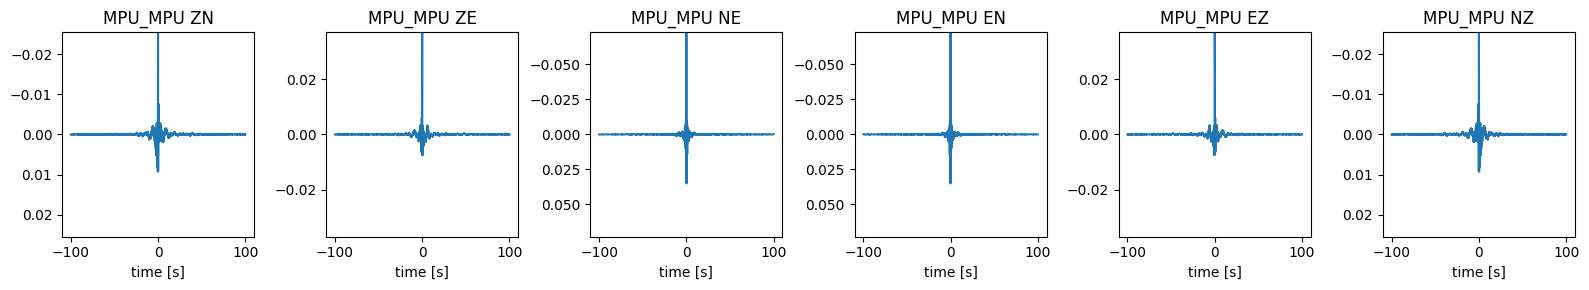

In [6]:
# Ready to read in h5 file
stackf=np.ndarray((fnum,num_cmp,2,leng))  
print(stackf.shape)
vdist=np.zeros((fnum,1))  # S-R distance array
fname=[]                  # file name array


aa=0
# loop through each station-pair
for sfile in sfiles:
    ncmp=0
    sta_pair=sfile.split(path)[1].split(".h5")[0]
    fname.append(sta_pair)
    for ccomp in comp_arr:        
        print(aa, sfile, ccomp)
        # read stacked waveforms
        if ( read_pyasdf(sfile,ccomp) == None):
            continue
        dist,dt, tvec,sdata = read_pyasdf(sfile,ccomp) # read waveform from pyasdf 
        stackf[aa][ncmp]=[tvec,sdata]
        vdist[aa]=dist
        ncmp=ncmp+1
    plot_waveforms(num_cmp,stackf[aa],fname[aa],comp_arr)
    
    aa=aa+1
fnum=len(fname)


In [7]:
def plot_filtered_waveforms(freq,tt,wav,fname):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,3), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=max(wav[fb], key=abs)
        #absx=max(tt, key=abs)
        #ax[fb].set_xlim(absx*-1,absx)
        ax[fb].set_ylim(absy*-1,absy)
        ax[fb].plot(tt,wav[fb], "k-", linewidth=0.2)
        #ax[fb].plot(wav_fold[0],wav_fold[fb+1], "b-", linewidth=1)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude")
        ax[fb].set_title( "%s   %s   @%4.2f-%4.2f Hz" % ( fname,ccomp,fmin,fmax ) )
    
    fig.tight_layout()
    plt.show()

## Step 1 --- Calculation of mean-squared (MS) envelopes --> ***Eobs*** 
--> normalized MS envelope is referred to as the observed energy density Eobs 

MPU_MPU ZN


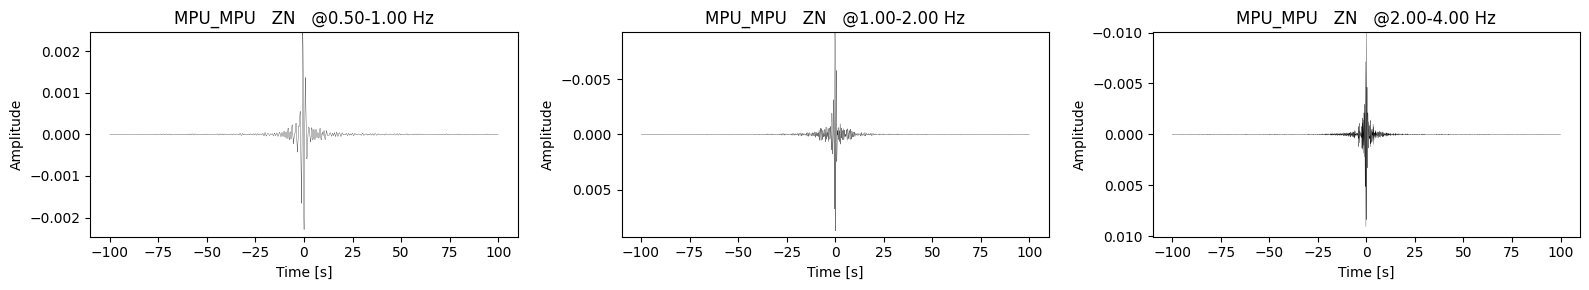

MPU_MPU ZE


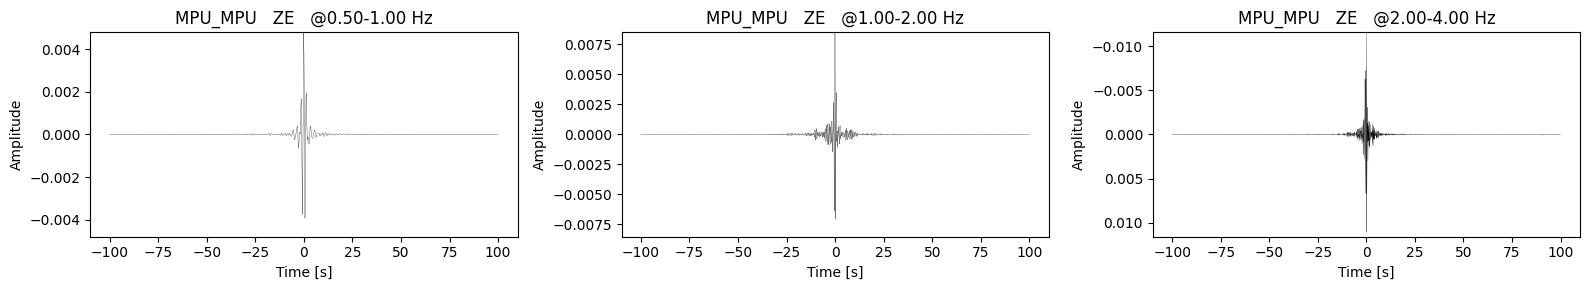

MPU_MPU NE


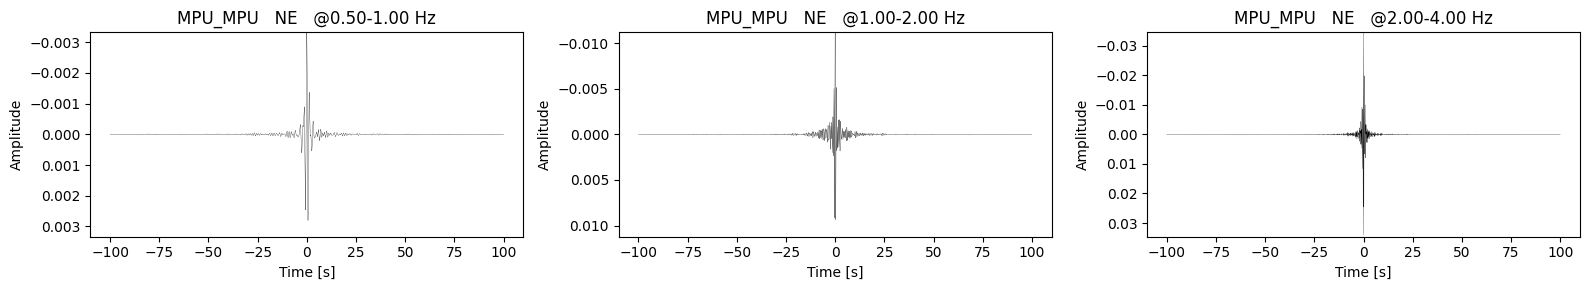

MPU_MPU EN


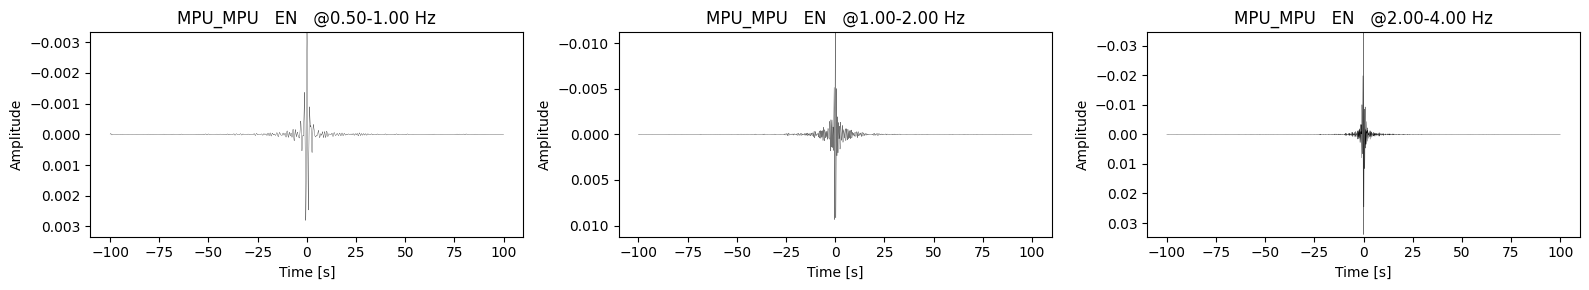

MPU_MPU EZ


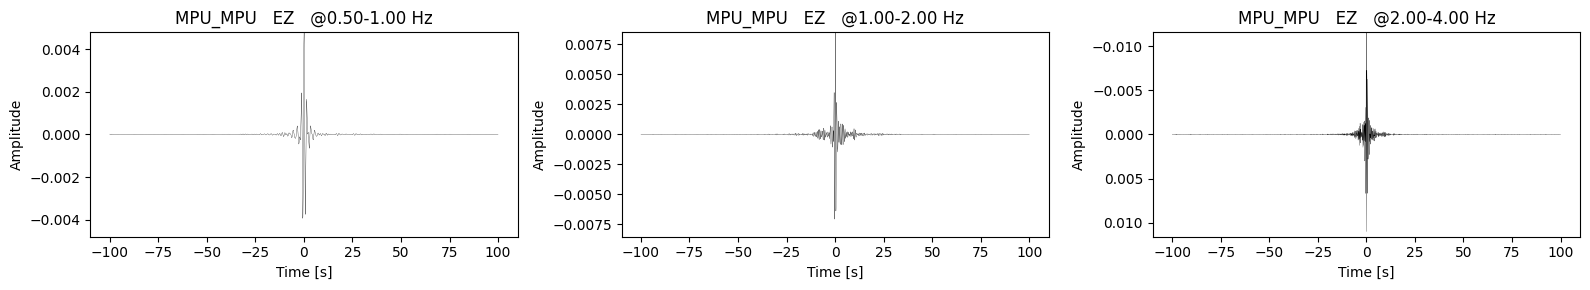

MPU_MPU NZ


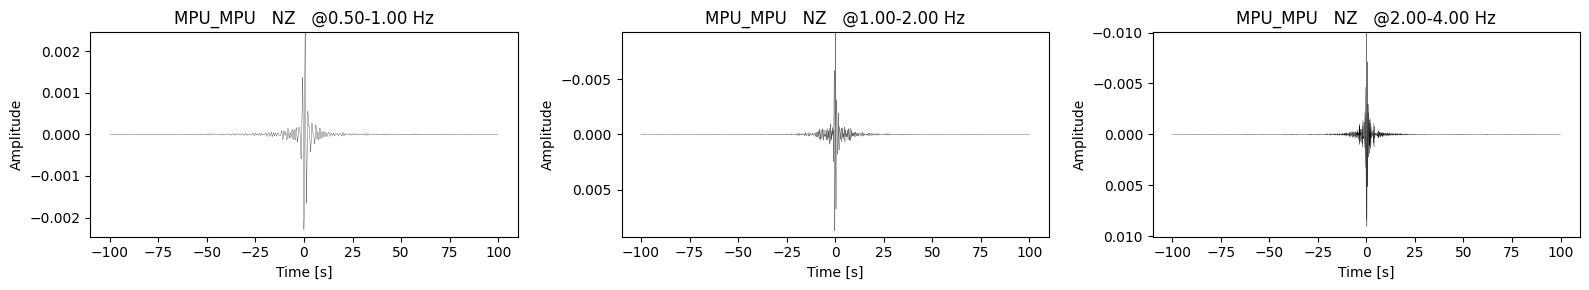

In [8]:
freq = [0.5, 1, 2, 4]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1

indx = npts // 2                      # half-side number of points
MSE=np.ndarray((fnum,num_cmp,nfreq+1,npts)) # filtered two-side averaged stack CF

for aa in range (fnum):
    dafbp=np.ndarray((nfreq,npts))
      
    for ncmp in range (len(comp_arr)):
        ccomp=comp_arr[ncmp]
        print(fname[aa],ccomp)
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]
            tt = np.arange(0, npts) * dt
            data = stackf[aa][ncmp][1]
            dafbp[fb] = bandpass(data, fmin, fmax, int(1 / dt), corners=4, zerophase=True)
        
        MSE[aa][ncmp]=[stackf[aa][ncmp][0],dafbp[0],dafbp[1],dafbp[2]] 
        plot_filtered_waveforms(freq,stackf[aa][ncmp][0],dafbp,fname[aa])



In [9]:
def plot_envelope(comp_arr,freq,msv,msv_mean,fname,vdist):
    
    nfreq = len(freq) - 1
    ncmp = len(comp_arr)
    
    fig, ax = plt.subplots(ncmp+1,nfreq, figsize=(16,10), sharex=False)   
    for n in  range(len(comp_arr)):
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]    
            ax[n,fb].plot(msv[n][0][:], msv[n][fb+1], "k-", linewidth=0.5)
            ax[n,fb].set_title("%s   %.2fkm  %s   @%4.2f-%4.2f Hz" % (fname,vdist,comp_arr[n],fmin,fmax))
            ax[n,fb].set_xlabel("Time [s]")
            ax[n,fb].set_ylabel("Amplitude")
            
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        ax[-1,fb].plot(msv_mean[0], msv_mean[fb+1], "b-", linewidth=1)
        ax[-1,fb].set_title(" Mean Squared Value %.2fkm  @%4.2f-%4.2f Hz" % (vdist,fmin,fmax))
        ax[-1,fb].set_xlabel("Time [s]")
        ax[-1,fb].set_ylabel("Amplitude")            

    plt.tight_layout()   
    plt.show()            
            

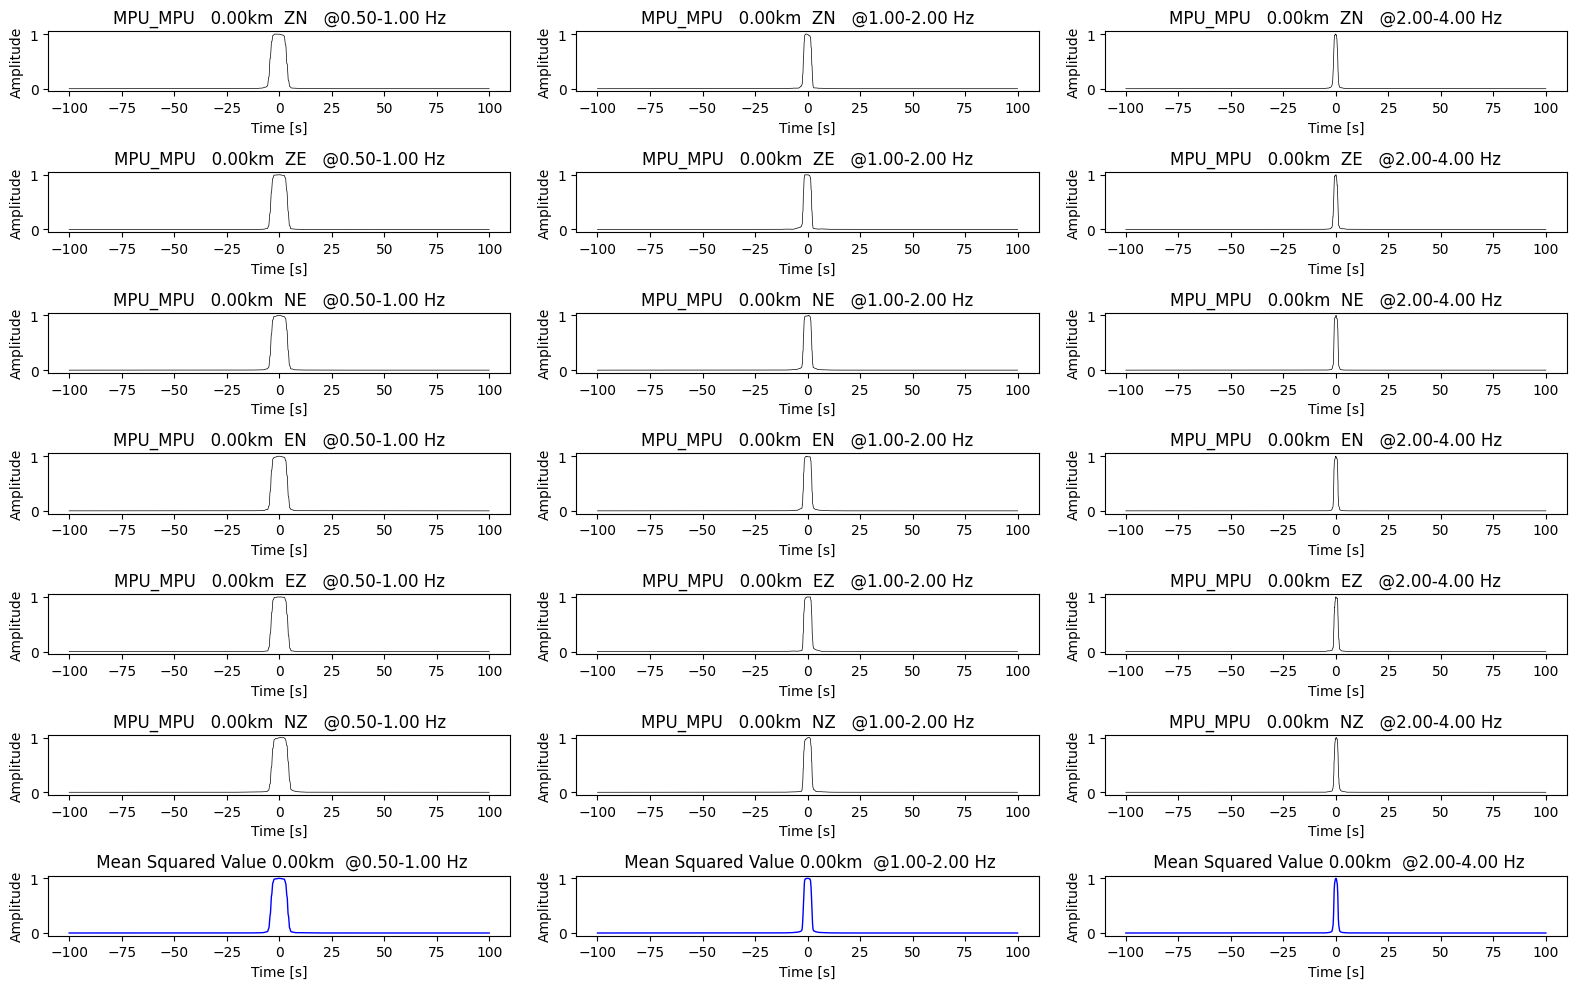

In [10]:
# get the mean-squared value on each componet and also the average waveform
msv=np.ndarray((fnum,num_cmp,nfreq+1,npts))
msv_mean=np.ndarray((fnum,nfreq+1,npts))
msv[:][:][:][:]=0.
msv_mean[:][:][:]=0.
#print(msv.shape)

winlen=[8,4,2]   # smoothing window lengths corresponding to the frequency bands
for aa in range(fnum):

    for ncmp in  range(len(comp_arr)):
        ccomp=comp_arr[ncmp]
        msv[aa][ncmp][0]=MSE[aa][ncmp][0][:]
        for fb in range(nfreq):
            data=MSE[aa][ncmp][fb+1][:]
            fmin=freq[fb]
            fmax=freq[fb+1]
            
            para = { 'winlen':winlen[fb], 'dt':dt , 'npts': len(data)}
            msv[aa][ncmp][fb+1]=get_smooth(data, para)
                    
            msv[aa][ncmp][fb+1]=msv[aa][ncmp][fb+1]/np.max(msv[aa][ncmp][fb+1])  # self-normalized 
    
    msv_mean[aa][0]=msv[aa][0][0][:]
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        for ncmp in range(len(comp_arr)):
            msv_mean[aa][fb+1]+=msv[aa][ncmp][fb+1][:]
        msv_mean[aa][fb+1]=msv_mean[aa][fb+1]/len(comp_arr)
        
    plot_envelope(comp_arr,freq,msv[aa],msv_mean[aa],fname[aa],vdist[aa])


In [11]:
def plot_fmsv_waveforms(freq,wav,fname,noise_level,twin):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,3), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=1 #max(wav[fb], key=abs)
        ax[fb].plot([wav[0][0],wav[0][-1]],[noise_level[fb],noise_level[fb]],c='blue',marker='.',ls='--', linewidth=2)
        
        ax[fb].plot([twin[fb][0],twin[fb][0]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
        ax[fb].plot([twin[fb][1],twin[fb][1]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
        ax[fb].set_yscale('log', base=10)
        ax[fb].plot(wav[0],wav[fb+1], "k-", linewidth=0.5)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude in log-scale")
        ax[fb].set_title( "%s   @%4.2f-%4.2f Hz" % ( fname,fmin,fmax ) )
    fig.tight_layout()
    plt.show()

0 0 695 9.831144966621382e-05 [9.85299342e-05] [10. 34.]
0 1 740 1.5945793323114087e-05 [1.62086957e-05] [ 5. 36.]
0 2 640 4.218817215334018e-06 [4.29267176e-06] [ 2. 31.]


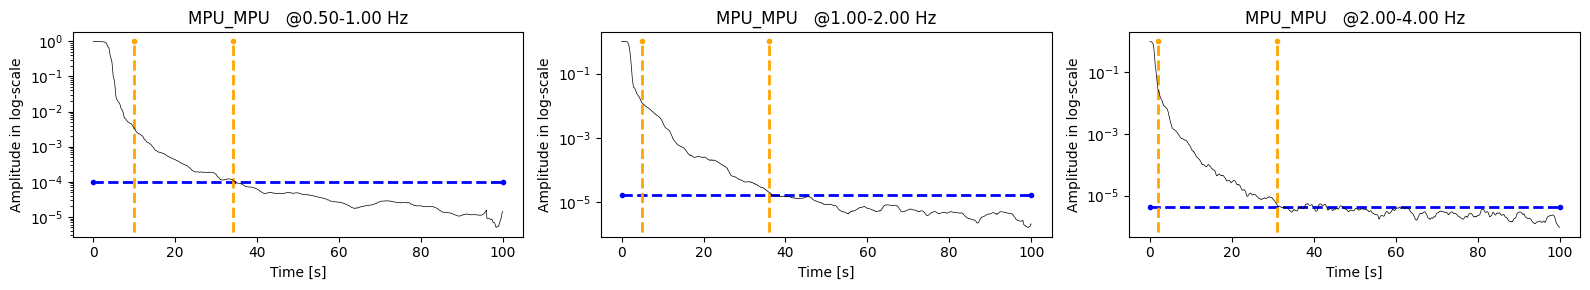

In [12]:
# get symmetric waveforms and determine the measuring window based on noise level (here is using 3 times of mad)
indx = npts // 2                      # half-side number of points
data_sym=np.ndarray((nfreq,indx+1)) # two-side averaged stack CF
fmsv_mean=np.ndarray((fnum,nfreq+1,indx+1))

# noise level setting
ratio=3
level=np.ndarray((fnum,nfreq,1))
twinbe=np.ndarray((fnum,nfreq,2))

for aa in range (fnum):
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]            # stack positive and negative lags  
        sym=get_symmetric(msv_mean[aa][fb+1],indx)
        data_sym[fb]=sym
        Val_mad=mad(sym)
        level[aa][fb]=Val_mad*ratio
        
        for pt in range(len(sym)):
            if (sym[pt] < float(level[aa][fb])):
                twinbe[aa][fb][0]=int((1/fmin)*5)
                twinbe[aa][fb][1]=int(msv[aa][0][0][indx+pt])
                print(aa,fb,pt,sym[pt],level[aa][fb],twinbe[aa][fb])
                break
    fmsv_mean[aa]=[msv[aa][0][0][indx:],data_sym[0],data_sym[1],data_sym[2]]
    plot_fmsv_waveforms(freq,fmsv_mean[aa],fname[aa],level[aa],twinbe[aa])


## Step 2 --- Calculation of synthesized energy densities (*Esyn*) via a grid search

### *The 2-D radiative transfer equation for scalar waves *(Shang and Gao 1988; Sato 1993)*

Assuming isotropic scattering and source radiation in infinite medium to calculate *synthesized energy densities Esyn* :

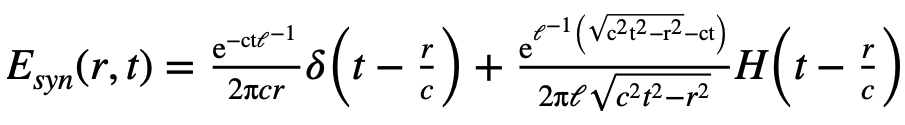

The sum of squared residuals (SSR) between Eobs and Esyn was calculated, and the values of the parameters l and b that minimize SSR through the grid search were determined. 

An energy density with the spatially homogeneous intrinsic absorption is obtained by multiplying e^-bt with the right-hand-side of Equation (1), where **b is intrinsic absorption parameter**

Here i is the number of time windows and j is the number of station pairs. from Hirose et al. (2022) -->

--> 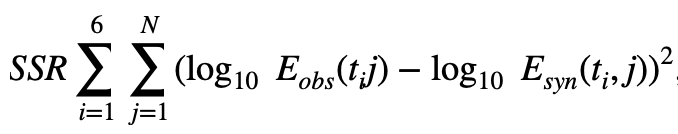

In [13]:
def plot_fitting_curves(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twin):
    numb=len(intrinsic_b)
    plt.figure(figsize=(8,2))
    for nb in range(numb):
    
        plt.yscale('log', base=10)
        #plt.xlim(0,120) 
        pymin=np.min(Eobs[nb][:-2]/2)
        pymax=np.max(Eobs[nb][:-2]*2)
        plt.ylim( pymin , pymax )
        plt.plot( tt, Eobs[nb], "k-", linewidth=0.5)
        plt.plot( tt, Esyn[nb], "b-", linewidth=1)
        plt.plot([twin[0],twin[0],twin[-1],twin[-1],twin[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)
        #plt.plot([twin[-1],twin[-1]],[np.min(Eobs[nb][:-2]*2), np.max(Eobs[nb][:-2]/2)],"r", linewidth=1)

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f~%.2f"
            % ( fname,dist,fmin,fmax,mean_free,y[0],y[-1]))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()
                    

In [14]:
cvel=[2.6, 2.0, 1.8]    # Rayleigh wave velocities over the freqency bands
mfpx=np.zeros(1)        # mean_free_path search array
intby=np.zeros(30)      # intrinsic_b search array

In [15]:
# getting the sum of squared residuals (SSR) between Eobs and Esyn  
SSR_final=np.ndarray((len(mfpx),len(intby)))
SSR=np.ndarray((nfreq,len(mfpx),len(intby)))
SSR[:][:][:]=0.

for fb in range(nfreq):
    fmin=freq[fb]
    fmax=freq[fb+1]
    c=cvel[fb]
    SSR_final[:][:]=0.
    vdist[:]=0.000001  # To avoid zero value at denominator
    
    # parameters for getting the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':fb, 'vdist':vdist, 'npts':npts, 'dt':dt, 'cvel':c, \
        'mfp':mfpx, 'intb':intby,'twin':twinbe, 'fmsv':fmsv_mean }
    # call function get_SSR
    SSR_final, mfpx, intby = get_SSR(fnum, para )
    
    SSR[fb]=SSR_final

### Step 3 --- Determination of best-fit parameters

In [16]:
def plot_fitting_result(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twin,fmin,fmax):
    plt.figure(figsize=(6,2))
    plt.yscale('log', base=10)

    pymax=np.max(Eobs[:-2]*5)
    pymin=10**(-6)
    plt.ylim( pymin , pymax )
    plt.plot( tt, Eobs, "k-", linewidth=1)
    plt.plot( tt, Esyn, "b--", linewidth=1)
    plt.plot([twin[0],twin[0],twin[-1],twin[-1],twin[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, intrinsic b: %.2f"
            % ( fname,dist,fmin,fmax,intrinsic_b))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amp")
    plt.tight_layout()   
    plt.show()
                    

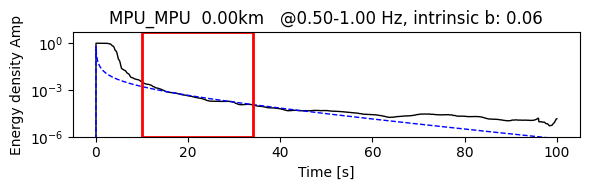

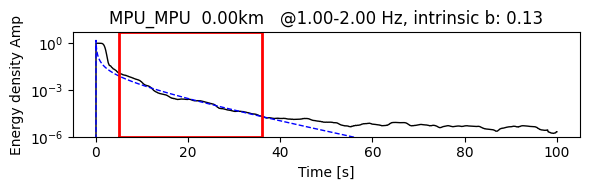

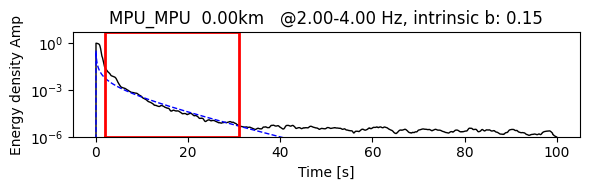

In [17]:
# getting the optimal value from the SSR
result_intb=np.ndarray((nfreq))
result_mfp=np.ndarray((nfreq))

Eobs=np.ndarray((nfreq,npts//2+1))
Esyn=np.ndarray((nfreq,npts//2+1))
aa=0
r=np.take(vdist[aa],0)+0.000001
for fb in range(nfreq): 
    fmin=freq[fb]
    fmax=freq[fb+1]

    # parameters for getting optimal value from the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':fb, 'fmin':fmin, 'fmax':fmax, 'vdist':vdist, 'npts':npts, 'dt':dt, 'cvel':c, 'filenum':aa, \
        'mfp':mfpx, 'intb':intby,'twin':twinbe, 'fmsv':fmsv_mean, 'SSR':SSR , 'sta':sta_pair}
    # call function get_optimal
    result_intb[fb], result_mfp[fb], Eobs[fb], Esyn[fb] = get_optimal(fnum,para)
    
    plot_fitting_result(result_mfp[fb],result_intb[fb],fmsv_mean[aa][0][:],
                        Eobs[fb],Esyn[fb],sta_pair,vdist[aa],twinbe[aa][fb],fmin,fmax)